In [2]:
!pip install textblob
!python -m textblob.download_corpora


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

In [9]:
import pandas as pd
from textblob import TextBlob
from tqdm import tqdm

# Load IMDb dataset (adjust path if needed)
df = pd.read_csv("/IMDB Dataset.csv")

# Define a function to classify sentiment using TextBlob
def classify_sentiment(text):
    analysis = TextBlob(text).sentiment.polarity  # Get polarity score (-1 to 1)
    if analysis > 0.2:
        return "positive"  # Positive sentiment
    elif analysis < -0.2:
        return "negative"  # Negative sentiment
    else:
        return "neutral"  # Newly added class

# Apply classification to all reviews
tqdm.pandas()  # Enable progress bar for large datasets
df["sentiment"] = df["review"].progress_apply(classify_sentiment)

# Convert labels to numeric format
df["label"] = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Print new label distribution
print("Class Distribution after relabeling:")
print(df["label"].value_counts())

# Save the new dataset
df.to_csv("IMDB_Multiclass_Dataset.csv", index=False)
print("✅ Saved the modified dataset with neutral sentiment!")


100%|██████████| 50000/50000 [01:26<00:00, 578.45it/s]


Class Distribution after relabeling:
label
1    35448
2    12845
0     1707
Name: count, dtype: int64
✅ Saved the modified dataset with neutral sentiment!


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [11]:
# Load IMDb dataset (after adding neutral sentiment)
df = pd.read_csv("IMDB_Multiclass_Dataset.csv")

In [12]:
# Check dataset structure
print(df.head())
print("Class Distribution:")
print(df['sentiment'].value_counts())

                                              review sentiment  label
0  One of the other reviewers has mentioned that ...   neutral      1
1  A wonderful little production. <br /><br />The...   neutral      1
2  I thought this was a wonderful way to spend ti...  positive      2
3  Basically there's a family where a little boy ...   neutral      1
4  Petter Mattei's "Love in the Time of Money" is...  positive      2
Class Distribution:
sentiment
neutral     35448
positive    12845
negative     1707
Name: count, dtype: int64


In [13]:
# Convert labels to numerical values (0=Negative, 1=Neutral, 2=Positive)
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['sentiment'] = df['sentiment'].map(label_mapping)

In [14]:
# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['review'])
y = df['label']

In [15]:
# Split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# Train Multinomial Naïve Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_preds = mnb.predict(X_test)
mnb_proba = mnb.predict_proba(X_test)  # Predicted probabilities


In [17]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

In [18]:
# Convert labels to One-Hot Encoding for AUC calculation
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))

In [19]:
# Define evaluation function
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n📊 Model Performance: {model_name}\n")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
    auc_score = roc_auc_score(y_test_encoded, y_proba, average='weighted', multi_class='ovr')
    print("AUC:", auc_score)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


📊 Model Performance: Multinomial Naïve Bayes

Accuracy: 0.7653
Precision: 0.7468964332932683
Recall: 0.7653
F1-score: 0.7161807039568542
AUC: 0.8210149744324757


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


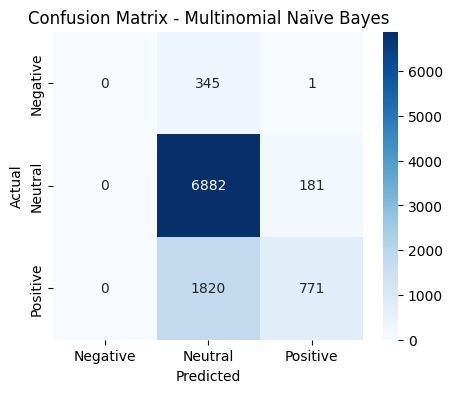


📊 Model Performance: Random Forest

Accuracy: 0.7926
Precision: 0.8101010642862558
Recall: 0.7926
F1-score: 0.7556638517912827
AUC: 0.8551702276280381


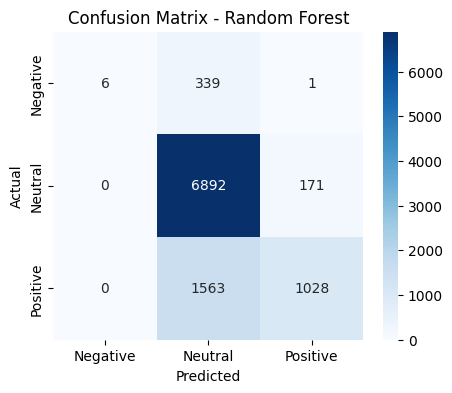

In [20]:
# Evaluate both models
evaluate_model(y_test, mnb_preds, mnb_proba, "Multinomial Naïve Bayes")
evaluate_model(y_test, rf_preds, rf_proba, "Random Forest")

In [21]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score


In [22]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [42]:
# Load Modified IMDb Dataset
df = pd.read_csv("IMDB_Multiclass_Dataset.csv")  # Ensure dataset includes neutral sentiment


In [43]:
# Check for NaN values and remove them
df.dropna(subset=['sentiment'], inplace=True)

# Convert sentiment labels from strings to integers
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df['sentiment'] = df['sentiment'].map(label_mapping)

# Ensure no NaN values exist after mapping
df.dropna(subset=['sentiment'], inplace=True)  # Remove any rows with unmapped labels
df['sentiment'] = df['sentiment'].astype(int)  # Convert to integer type


In [44]:
# Preprocessing: Tokenization & Encoding
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [45]:
class IMDbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)


    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        label = int(self.labels[idx])  # Ensure label is an integer
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(int(self.labels[idx]), dtype=torch.long)  # Ensure labels are integers

        }


In [46]:
# Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42, stratify=df['sentiment']
)

train_dataset = IMDbDataset(train_texts, train_labels, tokenizer)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [47]:
# Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [48]:
# Define Optimizer and Loss Function
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training Loop
def train_model(model, train_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

train_model(model, train_loader)

In [ ]:
# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(pd.get_dummies(all_labels), np.array(all_probs), multi_class='ovr')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"AUC: {auc}")

evaluate_model(model, test_loader)
